In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE, plot_ale

import shap
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pylab as pl


plt.rcParams.update({'font.size': 18})

# print the JS visualization code to the notebook
shap.initjs()


In [3]:

from new_plot import *
set_things()

# from shadow.plot import *

ModuleNotFoundError: No module named 'new_plot'

In [12]:
data1=pd.read_csv("ExcavationDI.csv")
data1.head()

,Sl,Dia,BucketCapacity,Experience,SoilStrata,Productivity
0,1,100,1.1,3,6,9.5
1,2,100,0.9,3,5,9.2
2,3,200,1.1,3,5,13.2
3,4,100,1.1,5,5,10.5
4,5,800,0.9,7,4,23.0


In [13]:
len(data1)

130

In [14]:
import subprocess


In [15]:
data=data1.loc[:, 'Dia':'Productivity']
data.head()

,Dia,BucketCapacity,Experience,SoilStrata,Productivity
0,100,1.1,3,6,9.5
1,100,0.9,3,5,9.2
2,200,1.1,3,5,13.2
3,100,1.1,5,5,10.5
4,800,0.9,7,4,23.0


In [16]:
data1.describe()

,Sl,Dia,BucketCapacity,Experience,SoilStrata,Productivity
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,65.500000,316.153846,1.041538,5.092308,5.669231,15.329231
std,37.671829,237.494625,0.091316,1.137426,2.984166,4.144473
min,1.000000,100.000000,0.900000,3.000000,2.000000,9.000000
25%,33.250000,150.000000,0.900000,5.000000,4.000000,12.500000
50%,65.500000,200.000000,1.100000,5.000000,5.000000,14.000000
75%,97.750000,450.000000,1.100000,5.000000,6.000000,18.575000
max,130.000000,900.000000,1.100000,7.000000,15.000000,24.000000


In [19]:
# Generate X and y data
X = data.loc[:, data.columns != 'Productivity']
y=data['Productivity']
#X.head()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def get_score(base='Training', actual=0,predicted=0):
    r2 = r2_score(actual,predicted)
    mae = mean_absolute_error(actual,predicted)
    mse = mean_squared_error(actual,predicted)
    print(base,r2.round(3),mae.round(3),mse.round(3))
    return r2,mae,mse

In [22]:
import pickle
rng = np.random.seed(2021)
np.random.randint(100)

85

In [23]:
# Split the data into training and test(I USED UNSCALLED DATA)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [24]:
# np.random.set_state(split)
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=453)
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train,test_size=0.25,random_state=int(13511))
scale = False
if scale:
    scaler=StandardScaler().fit(X_train)
    x_train=scaler.transform(X_train)
    x_val=scaler.transform(X_val)
    x_test=scaler.transform(X_test)
else:
    x_train=X_train
    x_test=X_test
    x_val=X_val

In [25]:
x_train.shape, x_val.shape, x_test.shape

((78, 4), (26, 4), (26, 4))

In [26]:
#Xg boost training(SKEW BRIDGE EXAMPLE)
# import xgboost as xgb
# from xgboost import plot_importance
# XGB_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)
# XGB_model=XGB_model.fit(X_train, y_train)

In [27]:
#Xg boost training(UNSCALLED DATA, NEW DI PIPE FILE)
from xgboost import XGBRegressor

xgbr=XGBRegressor(verbosity=0,n_estimators=10
            , max_depth=5, random_state=2021)
X_model=xgbr.fit(x_train,y_train)
get_score('Training',actual=y_train,predicted=X_model.predict(x_train))
get_score('validation',actual=y_val,predicted=X_model.predict(x_val))
get_score('Test',actual=y_test,predicted=X_model.predict(x_test))

Training 0.972 0.552 0.492
validation 0.987 0.332 0.174
Test 0.956 0.635 0.814


(0.956378153334907, 0.6345222326425406, 0.8138520188783318)

In [28]:
# Print the MSE
mean_squared_error(y_test, X_model.predict(x_test))

0.8138520188783318

In [29]:
feature_names = X.columns
print(feature_names)

Index(['Dia', 'BucketCapacity', 'Experience', 'SoilStrata'], dtype='object')


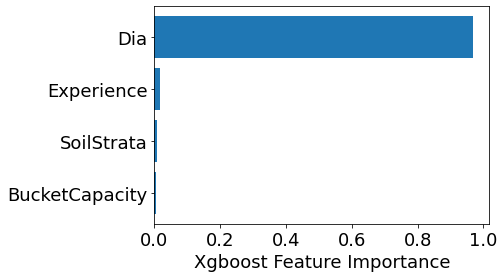

In [30]:
sorted_idx = X_model.feature_importances_.argsort()
#plt.figure(figsize=(4,12))
plt.barh(feature_names[sorted_idx], X_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.grid(False)
plt.savefig('XgBoost feature importance.png')

In [31]:
#ALE
XGB_ale = ALE(X_model.predict, feature_names=feature_names, target_names=['Productivity'])

In [32]:
XGB_exp = XGB_ale.explain(x_train.values)

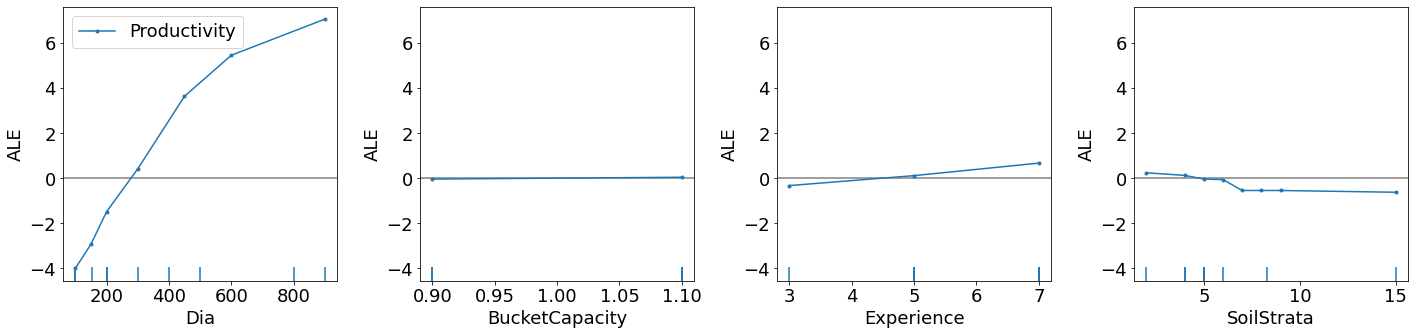

In [33]:

# NOT RUNNING ?? SOMETHING WRONG IN THE ABOVE CELL. was running when i used scalled values(as shown in the code)
plot_ale(XGB_exp, n_cols=4, fig_kw={'figwidth':20, 'figheight': 5});



ax=plt.gca()
ax.xaxis.set_tick_params(direction='out')
plt.savefig('ALE Plots.png')

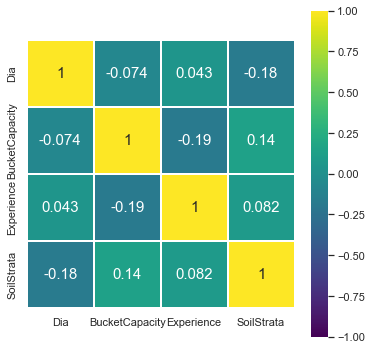

In [34]:
#(SIZE OF LABELS TO BE INCREASED, NOT READABLE)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

corr = data.drop('Productivity', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(6, 6))

sns.heatmap(corr[(corr >= 0.0) | (corr <= -0.0)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 15}, square=True);
 
    
plt.savefig('heat map.png')

In [35]:
# X_shap = scaler.transform(X)
# X_shap = pd.DataFrame(X_shap, columns = X.columns)
explainer = shap.TreeExplainer(X_model)
shap_values = explainer.shap_values(x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [36]:
# Single value explainer(??????)

shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])





In [37]:
help(shap.force_plot)

Help on function force in module shap.plots._force:

force(base_value, shap_values=None, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0, contribution_threshold=0.05)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, an

In [38]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

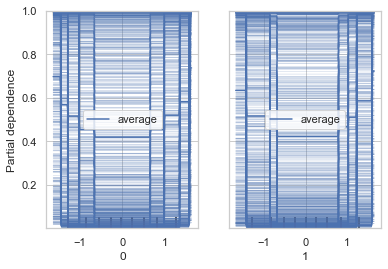

In [40]:
#PDP
#(No labelling on the x axis,-ve values, grid in the backgrouund to be removed)
X, y = make_hastie_10_2(random_state=0)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X, y)

features = [0,1]
PartialDependenceDisplay.from_estimator(clf, X, features,kind='both')
fig=plt.gca()
fig.spines['top'].set_visible(True) 
fig.spines['right'].set_visible(True)
fig.spines['left'].set_visible(True)

In [43]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

print("Training MLPRegressor...")
tic = time()
est = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    ),
)
est.fit(x_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(x_test, y_test):.2f}")

Training MLPRegressor...
done in 0.052s
Test R2 score: 0.21


n_quantiles (1000) is greater than the total number of samples (78). n_quantiles is set to n_samples.


Computing partial dependence plots...
done in 4.489s


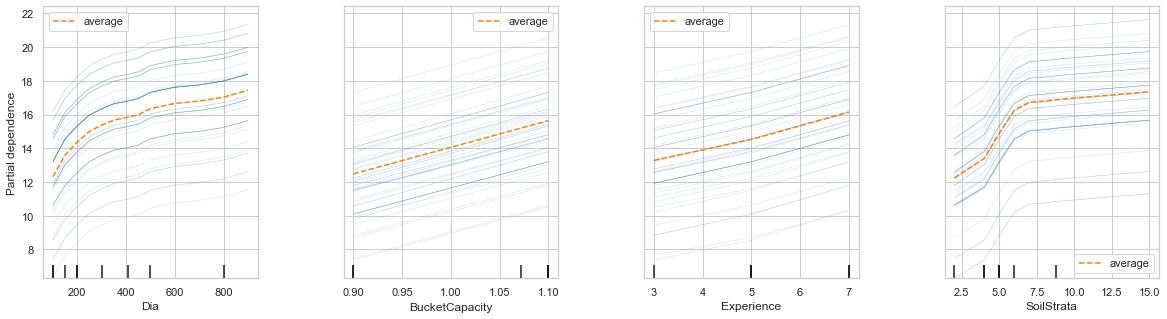

In [44]:
#GRAPHS CUTTING INTO EACH OTHER. NEED EDITTING. THERE'S NO SPACING 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

print("Computing partial dependence plots...")
#tic = time()
features = ["Dia", "BucketCapacity", "Experience", "SoilStrata"]
display = PartialDependenceDisplay.from_estimator(
    est,
    x_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    n_cols=4,
    grid_resolution=20,
    random_state=0,
   
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
print(f"done in {time() - tic:.3f}s")
# display.figure_.suptitle(
#     "Partial dependence of Productivity on feature values\n"
#     "for the dataset, with MLPRegressor"
#)
fig = plt.gcf()

fig.set_size_inches(20, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
#plt.savefig('skew_bridge_PDP.eps',format='eps', dpi=1000)
#display.figure_.subplots_adjust(hspace=0.5)
plt.savefig('PDPlots.png')

In [45]:
#gradient boosting
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor(random_state=0)
est.fit(x_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(x_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.071s
Test R2 score: 0.94


Computing partial dependence plots...
done in 0.383s


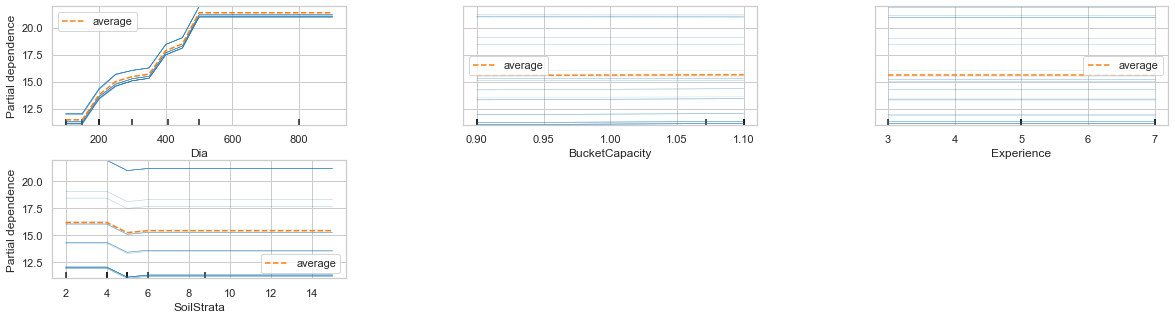

In [46]:
print("Computing partial dependence plots...")
tic = time()
display = PartialDependenceDisplay.from_estimator(
    est,
    x_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
print(f"done in {time() - tic:.3f}s")
# display.figure_.suptitle(
#     "Partial dependence of Productivity on feature valuess\n"
#     "for the Data set, with Gradient Boosting"
# )
fig = plt.gcf()

fig.set_size_inches(20, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

In [47]:
ff=fig.get_axes()[1]
leg=ff.get_children()[-2]
leg

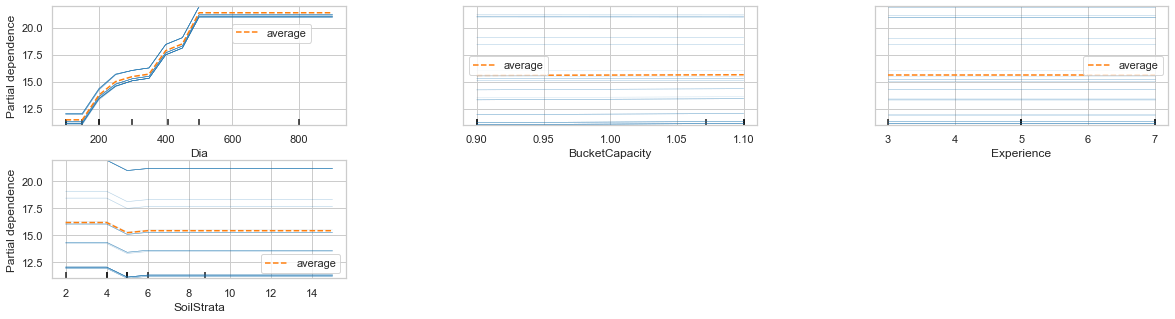

In [48]:
leg.set_bbox_to_anchor([.9,0.9])
fig

In [49]:
'Dia', c'BucketCapacity', 'Experience', 'SoilStrata

SyntaxError: invalid syntax (<ipython-input-49-ca47d4d3c0b4>, line 1)

Computing partial dependence plots...
done in 1.963s


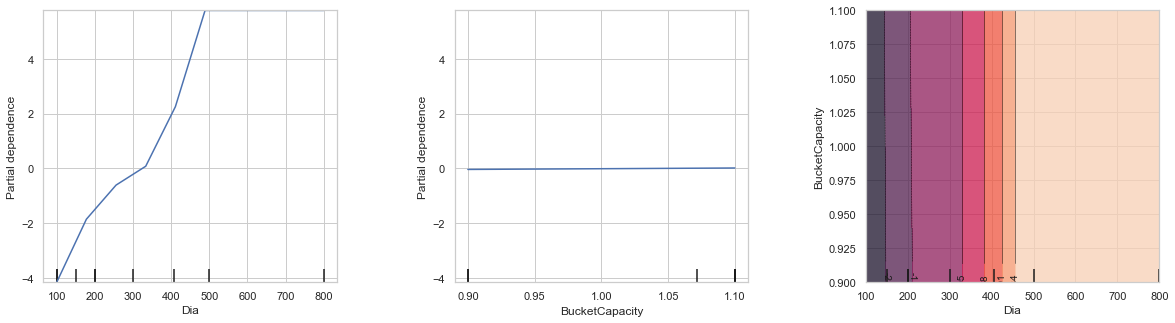

In [50]:
#2D intraction plots
#graphs cannot be read totally! editting required!
features = ["Dia", "BucketCapacity",("Dia", "BucketCapacity")]
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = PartialDependenceDisplay.from_estimator(
    est,
    x_train,
    features,
    kind="average",
    n_jobs=2,
    grid_resolution=10,
    ax=ax,
)
print(f"done in {time() - tic:.3f}s")
fig = plt.gcf()

fig.set_size_inches(20, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
# display.figure_.suptitle(
#     "Partial dependence of Productivity on feature values\n"
#     "for the given dataset, with Gradient Boosting"
# )
# display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('Dia BC.png')

Computing partial dependence plots...
done in 0.154s


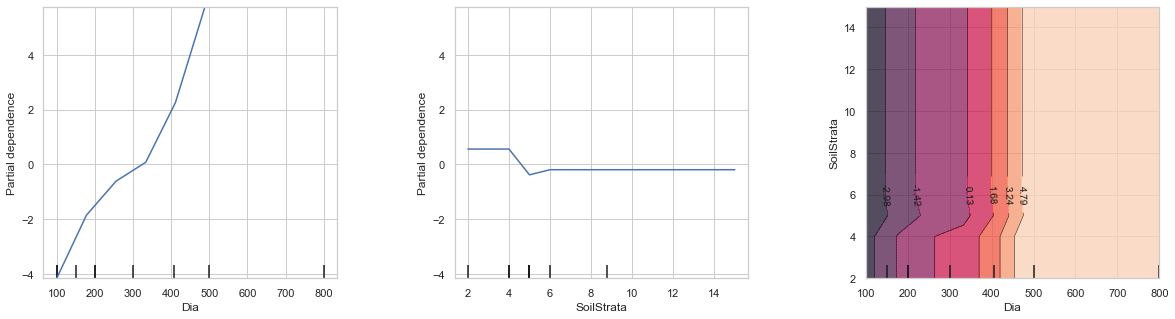

In [51]:
features = ["Dia", "SoilStrata",("Dia", "SoilStrata")]
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = PartialDependenceDisplay.from_estimator(
    est,
    x_train,
    features,
    kind="average",
    n_jobs=2,
    grid_resolution=10,
    ax=ax,
)
print(f"done in {time() - tic:.3f}s")
fig = plt.gcf()

fig.set_size_inches(20, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
# display.figure_.suptitle(
#     "Partial dependence of Productivity on feature values\n"
#     "for the given dataset, with Gradient Boosting"
# )
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('Dia SS.png')

Computing partial dependence plots...
done in 0.162s


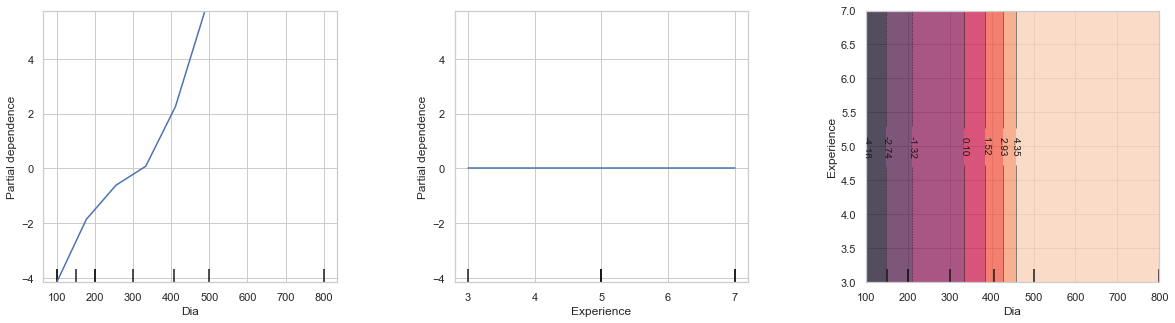

In [52]:
features = ["Dia", "Experience",("Dia", "Experience")]
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = PartialDependenceDisplay.from_estimator(
    est,
    x_train,
    features,
    kind="average",
    n_jobs=2,
    grid_resolution=10,
    ax=ax,
)
print(f"done in {time() - tic:.3f}s")
fig = plt.gcf()

fig.set_size_inches(20, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
# display.figure_.suptitle(
#     "Partial dependence of Productivity on feature values\n"
#     "for the given dataset, with Gradient Boosting"
# )
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('Dia Exp.png')

Computing partial dependence plots...
done in 0.186s


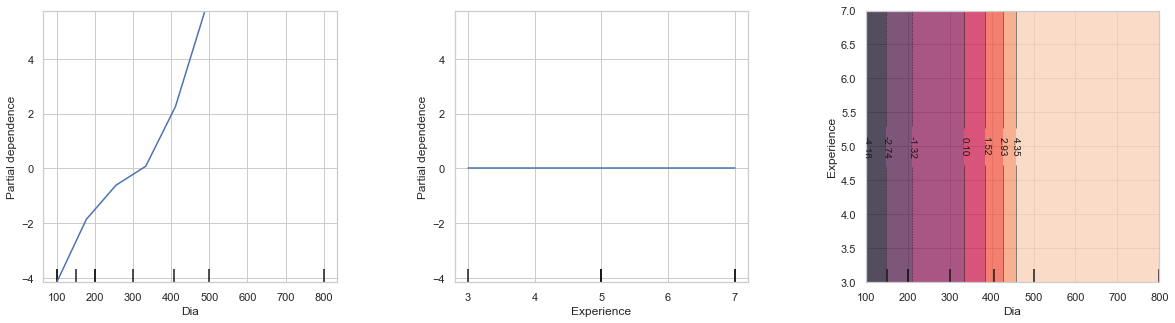

In [53]:
features = ["Dia", "Experience",("Dia", "Experience")]
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = PartialDependenceDisplay.from_estimator(
    est,
    x_train,
    features,
    kind="average",
    n_jobs=2,
    grid_resolution=10,
    ax=ax,
)
print(f"done in {time() - tic:.3f}s")
fig = plt.gcf()

fig.set_size_inches(20, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
# display.figure_.suptitle(
#     "Partial dependence of Productivity on feature values\n"
#     "for the given dataset, with Gradient Boosting"
# )
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('Dia Exp.png')

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


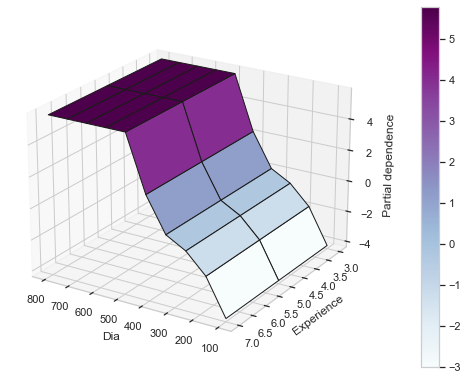

<Figure size 432x288 with 0 Axes>

In [54]:
#3D intraction plots 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ("Dia", "Experience")
pdp = partial_dependence(
    est, x_train, features=features, kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
# plt.suptitle(
#     "Partial dependence of Productivity on median\n"
#     "Dia and average experience, with Gradient Boosting"
# )
fig = plt.gcf()

fig.set_size_inches(15, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
plt.subplots_adjust(top=0.9)
plt.show()
plt.savefig('intraction 3D .png')

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


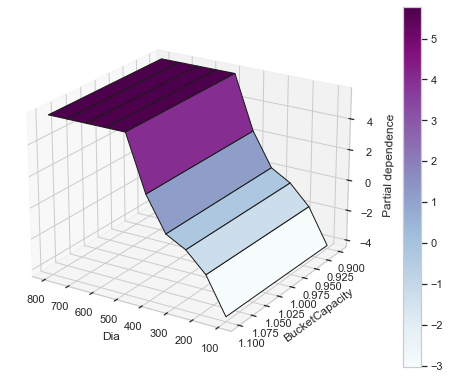

<Figure size 432x288 with 0 Axes>

In [55]:
#3D intraction plots 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ("Dia", "BucketCapacity")
pdp = partial_dependence(
    est, x_train, features=features, kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
# plt.suptitle(
#     "Partial dependence of Productivity on median\n"
#     "Dia and average experience, with Gradient Boosting"
# )
fig = plt.gcf()

fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
plt.subplots_adjust(top=0.9)
plt.show()
plt.savefig('3D 1.png')

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


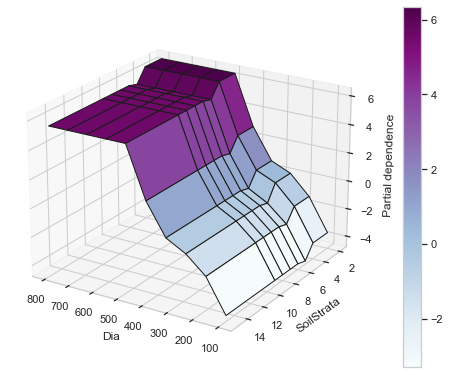

<Figure size 432x288 with 0 Axes>

In [56]:
#3D intraction plots 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ("Dia", "SoilStrata")
pdp = partial_dependence(
    est, x_train, features=features, kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
# plt.suptitle(
#     "Partial dependence of Productivity on median\n"
#     "Dia and average experience, with Gradient Boosting"
# )
fig = plt.gcf()

fig.set_size_inches(10, 5)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
plt.subplots_adjust(top=0.9)
plt.show()
plt.savefig('3D 1.png')